# Rearreglo de datos

Hasta el momento hemos trabajado con datos que ya han sido arreglados en forma que el análisis estadístico es sencillo, pero esto no siempre ocurre en la realidad, de hecho, la gran mayoría de las veces no contamos con datos arreglados en exactamente la forma en que necesitamos para algún análisis o visualización.

En esta libreta veremos algunos métodos para manipular arreglos de datos como lo deseemos.

:::{tip}
Revisa el acordeón de pandas en los  [recursos](#acordeones-target).
:::

## Librerías

In [1]:
import pandas as pd
import statsmodels.api as sm
import seaborn as sns


print('Librerías importadas')

Librerías importadas


## Melt, cambiar de formato ancho a largo

Trabajaremos con un dataset muy sencillo, con datos inventados. Los datos simulan un estudio en el cual se recolectó información de una medición `X` a lo largo de 3 días para los sujetos A, B, C, D y E.

In [2]:
wide = pd.DataFrame({
    'sujeto': ['A', 'B', 'C', 'D', 'E'],
    'edad':   [18,   23,  42,  32,  28],
    'sexo':   [0,     1,   1,   0,   1],
    'dia1':   [5,     3,   6,   8,   2],
    'dia2':   [6,     2,   7,   4,   5],
    'dia3':   [7,     4,   8,   3,   4],
})
wide

,sujeto,edad,sexo,dia1,dia2,dia3
0,A,18,0,5,6,7
1,B,23,1,3,2,4
2,C,42,1,6,7,8
3,D,32,0,8,4,3
4,E,28,1,2,5,4


Nuestro objetivo es convertir este dataset "ancho" en formato "largo" o "tidy". Para ello, necesitamos que exista una sola columna de "tiempo" y otra de "medición", pero sin perder la información sobre el sexo y la edad de cada sujeto.

Para hacerlo utilizamos el método `DataFrame.melt` el cual toma los siguientes argumentos:
- id_vars: Variables que se van a mantener constantes en cada fila, las que no cambian en cada día.
- value_vars: Variables que queremos juntar en una sola columna..
- var_name: Nombre de la variable (los días), defecto es "variable"
- value_name: Nombre de la variable del valor (la medición), por defecto es "value.
- col_level: Útil cuando hay multi-índices.
- ignore_index: Si es verdadero se ignora el índice original.


In [3]:
long = wide.melt(
    id_vars=['sujeto', 'edad', 'sexo'], # repite en cada fila
    value_vars=['dia1', 'dia2', 'dia3'],# colapsa en una sola columna
    var_name='Día', # el nombre de la columna
    value_name='Medición', # el nombre del valor
    ignore_index=False, # para quedarnos con el índice original
)
long

,sujeto,edad,sexo,Día,Medición
0,A,18,0,dia1,5
1,B,23,1,dia1,3
2,C,42,1,dia1,6
3,D,32,0,dia1,8
4,E,28,1,dia1,2
0,A,18,0,dia2,6
1,B,23,1,dia2,2
2,C,42,1,dia2,7
3,D,32,0,dia2,4
4,E,28,1,dia2,5


### Para qué tener ordenados así los datos. 
Existen muchas razones, para los análisis de regresión y ANOVA de medidas repetidas es necesario, pero simplemente para visualizar también lo hace más fácil.

#### Visualización en formato ancho

<Axes: >

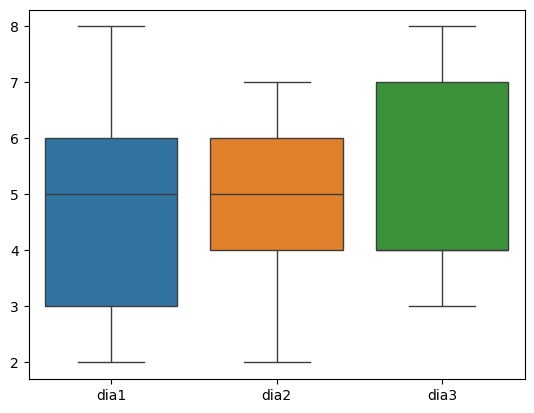

In [4]:
dias = ['dia1', 'dia2', 'dia3']
sns.boxplot(wide[dias])


Luce muy bien, pero las posibilidades de análisis son limitadas, no podemos comparar por ejemplo contra la variable sexo. En cambio, con el formato long is muy sencillo.

#### Visualización en formato largo

<Axes: xlabel='Día', ylabel='Medición'>

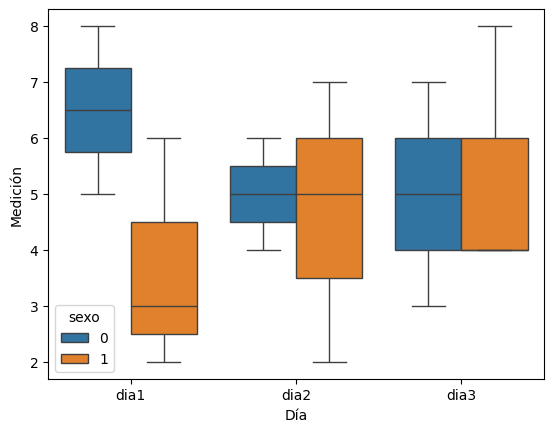

In [5]:
sns.boxplot(long, x='Día', y='Medición', hue='sexo')

## Pivot - cambiar de formato largo a ancho

A pesar de que los formatos largos son útiles para algunos análisis pueden no ser ideales para otros tipo, para esto puede ser que necesitemos ejecutar la versión opuesta y esto se logra con el método `DataFrame.pivot`.

Analicemos la ayuda disponible para el método.

In [6]:
help(pd.DataFrame.pivot)

Help on function pivot in module pandas.core.frame:

pivot(self, *, columns, index=<no_default>, values=<no_default>) -> 'DataFrame'
    Return reshaped DataFrame organized by given index / column values.

    Reshape data (produce a "pivot" table) based on column values. Uses
    unique values from specified `index` / `columns` to form axes of the
    resulting DataFrame. This function does not support data
    aggregation, multiple values will result in a MultiIndex in the
    columns. See the :ref:`User Guide <reshaping>` for more on reshaping.

    Parameters
    ----------
    columns : str or object or a list of str
        Column to use to make new frame's columns.
    index : str or object or a list of str, optional
        Column to use to make new frame's index. If not given, uses existing index.
    values : str, object or a list of the previous, optional
        Column(s) to use for populating new frame's values. If not
        specified, all remaining columns will be used 

La documentación es extensa, pero revísala con detenimiento, verás que incluso incluye ejemplos.

In [7]:
wide_back = long.pivot(
    # index='sujeto',
    columns='Día',
    values='Medición',
)
wide_back

Día,dia1,dia2,dia3
0,5,6,7
1,3,2,4
2,6,7,8
3,8,4,3
4,2,5,4


Desafortunadamente pivot no permite preservar los valores como la edad y el sexo, así que necesitamos juntar esa información nuevamente desde el formato long.

Como en el arreglo long los valores únicos se repiten, solo necesitamos seleccionar las columnas que queremos y quitar los duplicados.

In [8]:
meta = long[['sujeto', 'edad', 'sexo']].drop_duplicates()
meta

,sujeto,edad,sexo
0,A,18,0
1,B,23,1
2,C,42,1
3,D,32,0
4,E,28,1


Y ahora juntamos ambos arreglos y listo.

In [9]:
wide_final = wide_back.join(meta)
wide_final

,dia1,dia2,dia3,sujeto,edad,sexo
0,5,6,7,A,18,0
1,3,2,4,B,23,1
2,6,7,8,C,42,1
3,8,4,3,D,32,0
4,2,5,4,E,28,1


## Merge

Cuando tenemos dos conjuntos de datos que comparten una columna en común que identifica las filas de cada sujeto, podemos juntarlos con `DataFrame.merge`. Esta opción es similar a `join` pero es más flexible y poderoso.



In [10]:
glucosa = pd.DataFrame({
    'id': [1, 2, 3, 4, 5],
    'glucosa': [100, 98, 105, 125, 300],
})

datos_generales = pd.DataFrame({
    'identificación': [1, 2, 3, 4, 5],
    'edad': [25, 33, 52, 78, 37],
    'sexo': [1, 0, 0, 1, 1]
})
print(glucosa)
print(datos_generales)

   id  glucosa
0   1      100
1   2       98
2   3      105
3   4      125
4   5      300
   identificación  edad  sexo
0               1    25     1
1               2    33     0
2               3    52     0
3               4    78     1
4               5    37     1


Ahora utilicemos merge para combinarlos

In [11]:
datos_generales.merge(
    right=glucosa,
    left_on='identificación',
    right_on='id',
).drop(columns='id') # para no tener duplicada la fila id.

,identificación,edad,sexo,glucosa
0,1,25,1,100
1,2,33,0,98
2,3,52,0,105
3,4,78,1,125
4,5,37,1,300


## Ejercicio

Vamos a trabajar con el dataset `exercise` que viene incluido en `seaborn`. Este simula un estudio donde se midió la frecuencia cardiaca (`pulse`) en diferentes tipos de ejercicio y distintos tiempos de duración, agrupados por sujeto y condición física (`diet`).

### Carga del dataset

```python
import seaborn as sns
import pandas as pd

df = sns.load_dataset("exercise")
df.head()
```

Este dataset contiene las siguientes columnas:
- `id`: identificador del sujeto
- `diet`: tipo de dieta (`low fat`, `no fat`)
- `pulse`: frecuencia cardíaca
- `kind`: tipo de ejercicio (`rest`, `walking`, `running`)
- `time`: duración del ejercicio en minutos (`1 min`, `15 min`, `30 min`)

### Actividades

1. Reorganiza los datos en formato ancho, de modo que cada tipo de ejercicio (`kind`) sea una columna y los valores sean la frecuencia cardíaca (`pulse`). Usa `pivot_table` si hay duplicados.
2. Convierte nuevamente a formato largo, manteniendo `id`, `diet` y `time` como columnas fijas. Asegúrate de nombrar adecuadamente las nuevas columnas (`ejercicio`, `pulso`).
3. Calcula el promedio de frecuencia cardíaca por tipo de ejercicio utilizando `groupby`.
4. Genera un `boxplot` que compare la frecuencia cardíaca según el tipo de ejercicio, diferenciando por dieta (`diet`), usando el formato largo.
5. Calcula el cambio en frecuencia cardíaca entre reposo (`rest`) y caminata (`walking`) por sujeto y crea una nueva columna `delta_walk_rest`.
